In [1]:
import site, pathlib, subprocess, sys
sys.path.insert(0,"/home/mt622/GitHubRepos/FractionalBrownianMotion")
repo_root = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], text=True
).strip()
pth_dir = pathlib.Path(site.getsitepackages()[0])
(pth_dir / "namerepo_root.pth").write_text(repo_root + "\n")
print("Wrote", pth_dir / "namerepo_root.pth")

Wrote /home/mt622/GitHubRepos/FractionalBrownianMotion/.venv/lib/python3.10/site-packages/namerepo_root.pth


In [2]:
import pickle
from configs import project_config
import numpy as np
import torch
import os
from tqdm import tqdm
from src.classes.ClassConditionalStbleTgtMarkovianPostMeanDiffTrainer import \
    ConditionalStbleTgtMarkovianPostMeanDiffTrainer
from src.generative_modelling.data_processing import train_and_save_recursive_diffusion_model
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
from utils.data_processing import init_experiment, cleanup_experiment
from utils.math_functions import generate_fQuadSin
from utils.resource_logger import ResourceLogger

In [3]:
# Data parameters
from configs.RecursiveVPSDE.Markovian_fBiPotDDims.recursive_Markovian_PostMeanScore_fBiPot12Dims_T256_H05_tl_110data_StbleTgt import get_config
config = get_config()

In [5]:
assert (config.hurst == 0.5)
assert (config.early_stop_idx == 0)
assert (config.tdata_mult == 110)
#assert (config.sin_space_scale == 25.)
assert (config.feat_thresh == 1./100.)
print(config.scoreNet_trained_path, config.dataSize)
rng = np.random.default_rng()
scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(
    *config.model_parameters)
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)


/home/mt622/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0010FTh_PM_MLP_2LFac_fBiPot_12DDims_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-20b_00c_MLP_H4_CUp20_tl110 40000


In [6]:
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and "EE" in file:
        print(file)
        entered = True
        scoreModel.load_state_dict(torch.load(os.path.join(model_dir, file)))
assert entered

trained_rec_ST_0010FTh_PM_MLP_2LFac_fBiPot_12DDims_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-20b_00c_MLP_H4_CUp20_tl110_EENEp328


In [7]:
def experiment_MLP_1D_drifts(config, es,Xs, PM, onlyGauss=False):
    print("Beta Min : ", config.beta_min)
    if config.has_cuda:
        device = 0#int(os.environ["LOCAL_RANK"])
    else:
        print("Using CPU\n")
        device = torch.device("cpu")
    Xs = torch.Tensor(Xs).to(device)
    PM = PM.to(device)
    diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
    ts_step = config.deltaT
    print(config.scoreNet_trained_path)
    Xshape = config.ts_length
    num_taus = 10

    num_diff_times = config.max_diff_steps
    Ndiff_discretisation = config.max_diff_steps
    diffusion_times = torch.linspace(start=config.sample_eps, end=config.end_diff_time,
                                     steps=Ndiff_discretisation).to(device)

    features_tensor = torch.stack([Xs for _ in range(1)], dim=0).reshape(Xshape * 1, 1, -1).to(device)
    vec_Z_taus = diffusion.prior_sampling(shape=(Xshape * num_taus, 1, config.ts_dims)).to(device)

    # ts = []
    es = num_diff_times - es
    final_vec_mu_hats = np.zeros(
        (Xshape, num_diff_times, num_taus, config.ts_dims))  # Xvalues, DiffTimes, Ztaus, Ts_Dims
    
    ts = []
    # mu_hats_mean = np.zeros((tot_num_feats, num_taus))
    # mu_hats_std = np.zeros((tot_num_feats, num_taus))
    PM.eval()
    for difftime_idx in tqdm(np.arange(num_diff_times - 1, num_diff_times - es - 1, -1)): #difftime_idx >= num_diff_times - es:
        d = diffusion_times[Ndiff_discretisation - (num_diff_times - 1 - difftime_idx) - 1].to(device)
        diff_times = torch.stack([d for _ in range(Xshape)]).reshape(Xshape * 1).to(device)
        eff_times = diffusion.get_eff_times(diff_times=diff_times).unsqueeze(-1).unsqueeze(-1).to(device)
        vec_diff_times = torch.stack([diff_times for _ in range(num_taus)], dim=0).reshape(num_taus * Xshape)
        vec_eff_times = torch.stack([eff_times for _ in range(num_taus)], dim=0).reshape(num_taus * Xshape, 1, 1)
        vec_conditioner = torch.stack([features_tensor for _ in range(num_taus)], dim=0).reshape(
            num_taus * Xshape,
            1, -1)
        with torch.no_grad():
            if onlyGauss:
                scoreEval_vec_Z_taus = torch.randn_like(vec_Z_taus).to(device)
            else:
                scoreEval_vec_Z_taus = vec_Z_taus
            vec_predicted_score = PM.forward(inputs=scoreEval_vec_Z_taus, times=vec_diff_times, conditioner=vec_conditioner,
                                             eff_times=vec_eff_times)
        vec_scores, vec_drift, vec_diffParam = diffusion.get_conditional_reverse_diffusion(x=vec_Z_taus,
                                                                                           predicted_score=vec_predicted_score,
                                                                                           diff_index=torch.Tensor(
                                                                                               [int((
                                                                                                       num_diff_times - 1 - difftime_idx))]).to(
                                                                                               device),
                                                                                           max_diff_steps=Ndiff_discretisation)
        # assert np.allclose((scores- predicted_score).detach(), 0)
        beta_taus = torch.exp(-0.5 * eff_times[0, 0, 0]).to(device)
        sigma_taus = torch.pow(1. - torch.pow(beta_taus, 2), 0.5).to(device)
        final_mu_hats = (scoreEval_vec_Z_taus / (ts_step * beta_taus)) + ((
                                                                        (torch.pow(sigma_taus, 2) + (
                                                                                torch.pow(beta_taus * config.diffusion,
                                                                                          2) * ts_step)) / (
                                                                                ts_step * beta_taus)) * vec_scores)

        assert (final_mu_hats.shape == (num_taus * Xshape, 1, config.ts_dims))

        means = final_mu_hats.reshape((num_taus, Xshape, config.ts_dims))
        # print(vec_Z_taus.shape, vec_scores.shape)
        final_vec_mu_hats[:, difftime_idx,:, :] = means.permute((1, 0, 2)).cpu().numpy()
        vec_z = torch.randn_like(vec_drift).to(device)
        vec_Z_taus = vec_drift + vec_diffParam * vec_z
        difftime_idx -= 1
    assert (final_vec_mu_hats.shape == (Xshape, num_diff_times, num_taus, config.ts_dims))
    return final_vec_mu_hats[:, -es:, :, :]

In [8]:
Xshape = 256
if config.ndims == 12:
    Xs = np.concatenate([np.linspace(-5, 5, num=Xshape).reshape(-1,1), np.linspace(-4.7, 4.7, num=Xshape).reshape(-1,1), \
                            np.linspace(-4.4, 4.4, num=Xshape).reshape(-1,1), np.linspace(-4.2, 4.2, num=Xshape).reshape(-1,1), \
                            np.linspace(-4.05, 4.05, num=Xshape).reshape(-1,1), np.linspace(-3.9, 3.9, num=Xshape).reshape(-1,1), \
                            np.linspace(-3.7, 3.7, num=Xshape).reshape(-1,1), np.linspace(-3.6, 3.6, num=Xshape).reshape(-1,1), \
                            np.linspace(-3.55, 3.55, num=Xshape).reshape(-1,1),
                            np.linspace(-3.48, 3.48, num=Xshape).reshape(-1,1), \
                            np.linspace(-3.4, 3.4, num=Xshape).reshape(-1,1), np.linspace(-3.4, 3.4, num=Xshape).reshape(-1,1)],
                        axis=1)
elif config.ndims == 8:
    Xs = np.concatenate([np.linspace(-4.9, 4.9, num=Xshape).reshape(-1, 1), np.linspace(-4.4, 4.4, num=Xshape).reshape(-1,1), \
                            np.linspace(-4.05, 4.05, num=Xshape).reshape(-1,1), np.linspace(-3.9, 3.9, num=Xshape).reshape(-1,1), \
                            np.linspace(-3.7, 3.7, num=Xshape).reshape(-1,1), np.linspace(-3.6, 3.6, num=Xshape).reshape(-1,1), \
                            np.linspace(-3.5, 3.5, num=Xshape).reshape(-1,1), np.linspace(-3.4, 3.4, num=Xshape).reshape(-1,1)],
                        axis=1)

In [9]:
remote_file_path = project_config.ROOT_DIR+"data/" #/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/"
remote_file_path

'/home/mt622/GitHubRepos/FractionalBrownianMotion/data/'

In [10]:
es=0
DNonGauss = experiment_MLP_1D_drifts(PM=scoreModel,es=es, Xs=Xs, config=config, onlyGauss=False)
np.save(remote_file_path + "12DDimsBiPot_optimal_tau_experiment_DNonGauss.npy", DNonGauss)

DGauss = experiment_MLP_1D_drifts(PM=scoreModel,es=es, Xs=Xs, config=config, onlyGauss=True)
np.save(remote_file_path + "12DDimsBiPot_optimal_tau_experiment_DGauss.npy", DGauss)

Beta Min :  0.0
/home/mt622/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0010FTh_PM_MLP_2LFac_fBiPot_12DDims_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-20b_00c_MLP_H4_CUp20_tl110


100%|██████████| 10000/10000 [02:03<00:00, 81.06it/s]


Beta Min :  0.0
/home/mt622/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0010FTh_PM_MLP_2LFac_fBiPot_12DDims_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-20b_00c_MLP_H4_CUp20_tl110


100%|██████████| 10000/10000 [02:00<00:00, 82.70it/s]


In [11]:
true_drifts = -(4. * np.array(config.quartic_coeff) * np.power(Xs,
                                                                           3) + 2. * np.array(
                    config.quad_coeff) * Xs + np.array(config.const))
Gauss_errors = np.mean(DGauss, axis=2) - true_drifts[:, np.newaxis,:]
assert np.all(Gauss_errors.shape == (Xshape, DGauss.shape[1], config.ts_dims))
NonGauss_errors = np.mean(DNonGauss, axis=2) - true_drifts[:, np.newaxis,:]
assert np.all(NonGauss_errors.shape == (Xshape, DNonGauss.shape[1], config.ts_dims))
Gauss_errors = np.mean(np.sum(np.power(Gauss_errors,2), axis=-1), axis=0)
assert np.all(Gauss_errors.shape == (DGauss.shape[1],))
NonGauss_errors = np.mean(np.sum(np.power(NonGauss_errors,2), axis=-1), axis=0)
assert np.all(NonGauss_errors.shape == (DNonGauss.shape[1],))


In [23]:
Gauss_errors_std = np.sum(np.power(np.mean(DGauss, axis=2) - true_drifts[:, np.newaxis,:],2), axis=-1)
Gauss_errors_std = np.sqrt(np.mean(Gauss_errors_std**2, axis=0)-np.mean(Gauss_errors_std,axis=0)**2)
NonGauss_errors_std = np.sum(np.power(np.mean(DNonGauss, axis=2) - true_drifts[:, np.newaxis,:],2), axis=-1)
NonGauss_errors_std = np.sqrt(np.mean(NonGauss_errors_std**2, axis=0)-np.mean(NonGauss_errors_std,axis=0)**2)
NonGauss_errors_std

array([6.47122540e+09, 1.40240010e+09, 3.48652434e+08, ...,
       2.36967819e+04, 2.36972784e+04, 2.36970621e+04])

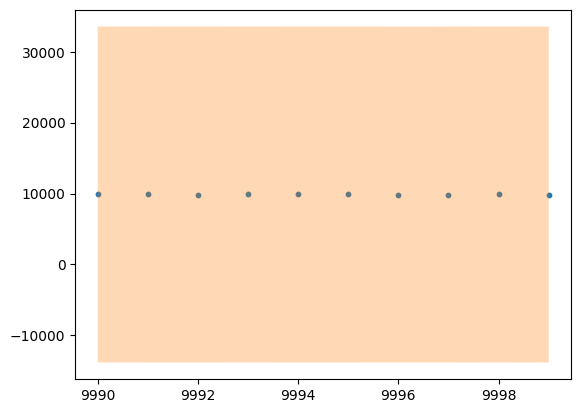

In [27]:
startidx=9990
plt.scatter(np.arange(startidx,Gauss_errors.shape[0]),Gauss_errors[startidx:], label="Gauss",s=10)
plt.fill_between(np.arange(startidx,Gauss_errors.shape[0]), Gauss_errors[startidx:]-Gauss_errors_std[startidx:],Gauss_errors[startidx:]+
Gauss_errors_std[startidx:],alpha=0.3)

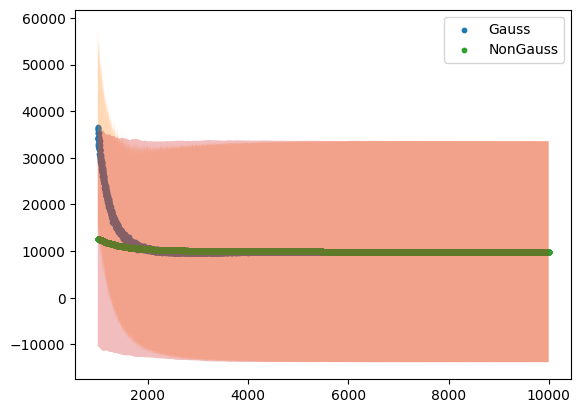

In [33]:
import matplotlib.pyplot as plt
startidx=1000
plt.scatter(np.arange(startidx,Gauss_errors.shape[0]),Gauss_errors[startidx:], label="Gauss",s=10)
plt.fill_between(np.arange(startidx,Gauss_errors.shape[0]), Gauss_errors[startidx:]-Gauss_errors_std[startidx:],Gauss_errors[startidx:]+
Gauss_errors_std[startidx:],alpha=0.3)
plt.scatter(np.arange(startidx,NonGauss_errors.shape[0]),NonGauss_errors[startidx:], label="NonGauss",s=10)
plt.fill_between(np.arange(startidx,NonGauss_errors.shape[0]), NonGauss_errors[startidx:]-NonGauss_errors_std[startidx:],NonGauss_errors[startidx:]+
NonGauss_errors_std[startidx:],alpha=0.3)
#plt.yscale("log")
plt.legend()
plt.show()
plt.close()